In [9]:
import os
import random
from datasets import load_dataset, Dataset
from tqdm import tqdm
import polars as pl
from concurrent.futures import ProcessPoolExecutor
import spacy
import numpy as np
from functools import partial
import re
from PIL import Image
import torch
import matplotlib.pyplot as plt

import torchvision
from torchvision.transforms.functional import InterpolationMode
from transformers import AutoTokenizer, AutoProcessor, AutoModelForSeq2SeqLM, AutoModel
import diffusers
from diffusers.image_processor import VaeImageProcessor
from diffusers import AutoencoderKL, DDPMScheduler

pl.Config.set_fmt_str_lengths(200)

/home/enric/projects/tiny_diffusion/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


polars.config.Config

In [10]:
PATH = '/mnt/sd1tb/tinydiffusion/dataset_v0/'

In [11]:
def show_image(df, idx=None):
    if idx is None:
        idx = random.randint(0, len(df))
    row = df[idx]
    path = row['path'][0]
    prompt = row['caption'][0]
    img = Image.open(path).convert('RGB').resize((256, 256))
    h, w = row['height'][0], row['width'][0]
    print(h, w)
    print(prompt)
    plt.figure(figsize=(8, 10))
    plt.imshow(img)
    # plt.title(prompt, {'fontsize': 14})
    plt.axis('off')

In [12]:
df_consolidated = pl.read_parquet(
    PATH + 'dataset_gold.parquet'
)
len(df_consolidated)

135524

In [13]:
df_consolidated.head(3)

shape: (3, 13)
┌────────────┬────────────┬────────────┬───────────┬───┬────────────┬──────┬───────────┬───────────┐
│ id         ┆ caption    ┆ url        ┆ key       ┆ … ┆ original_h ┆ exif ┆ sha256    ┆ path      │
│ ---        ┆ ---        ┆ ---        ┆ ---       ┆   ┆ eight      ┆ ---  ┆ ---       ┆ ---       │
│ str        ┆ str        ┆ str        ┆ str       ┆   ┆ ---        ┆ str  ┆ str       ┆ str       │
│            ┆            ┆            ┆           ┆   ┆ i32        ┆      ┆           ┆           │
╞════════════╪════════════╪════════════╪═══════════╪═══╪════════════╪══════╪═══════════╪═══════════╡
│ 2139075012 ┆ Mechanisms ┆ http://ima ┆ 000610003 ┆ … ┆ 720        ┆ {}   ┆ 66a8b029b ┆ /mnt/sd1t │
│ 276        ┆ controllin ┆ ges.slidep ┆           ┆   ┆            ┆      ┆ be749e599 ┆ b/tinydif │
│            ┆ g DOC      ┆ layer.com/ ┆           ┆   ┆            ┆      ┆ 7dfc1d7f2 ┆ fusion/da │
│            ┆ transport; ┆ 13/3905519 ┆           ┆   ┆            ┆      ┆ 70ce12fba ┆ taset_v0/ │
│            ┆ Surface    ┆ /slides/sl ┆           ┆   ┆            ┆      ┆ fe8bd027b ┆ imgs/0006 │
│            ┆ flow vs    ┆ ide_1.jpg  ┆           ┆   ┆            ┆      ┆ 7073130bb ┆ 1/0006100 │
│            ┆ pipes vs   ┆            ┆           ┆   ┆            ┆      ┆ 941dc1c91 ┆ 03.jpg    │
│            ┆ groundwate ┆            ┆           ┆   ┆            ┆      ┆ b         ┆           │
│            ┆ r Pippa    ┆            ┆           ┆   ┆            ┆      ┆           ┆           │
│            ┆ Chapman,   ┆            ┆           ┆   ┆            ┆      ┆           ┆           │
│            ┆ School of  ┆            ┆           ┆   ┆            ┆      ┆           ┆           │
│            ┆ Geography  ┆            ┆           ┆   ┆            ┆      ┆           ┆           │
│            ┆ University ┆            ┆           ┆   ┆            ┆      ┆           ┆           │
│            ┆ of Leeds   ┆            ┆           ┆   ┆            ┆      ┆           ┆           │
│            ┆ water@leed ┆            ┆           ┆   ┆            ┆      ┆           ┆           │
│            ┆ s          ┆            ┆           ┆   ┆            ┆      ┆           ┆           │
│ 4256716004 ┆ Who are    ┆ https://ww ┆ 000610006 ┆ … ┆ 620        ┆ {}   ┆ cfbe31db5 ┆ /mnt/sd1t │
│ 275        ┆ we? We are ┆ w.idlehear ┆           ┆   ┆            ┆      ┆ 3fe6052e5 ┆ b/tinydif │
│            ┆ children   ┆ ts.com/ima ┆           ┆   ┆            ┆      ┆ 16c8ca7a6 ┆ fusion/da │
│            ┆ of God.    ┆ ges/who-ar ┆           ┆   ┆            ┆      ┆ 4174298a0 ┆ taset_v0/ │
│            ┆ Our        ┆ e-we-we-ar ┆           ┆   ┆            ┆      ┆ ea64f6085 ┆ imgs/0006 │
│            ┆ potential  ┆ e-children ┆           ┆   ┆            ┆      ┆ 382d6f60d ┆ 1/0006100 │
│            ┆ is         ┆ -of-god-ou ┆           ┆   ┆            ┆      ┆ 88df85b61 ┆ 06.jpg    │
│            ┆ unlimited. ┆ r-potentia ┆           ┆   ┆            ┆      ┆ 1         ┆           │
│            ┆ Image      ┆ l-is-unlim ┆           ┆   ┆            ┆      ┆           ┆           │
│            ┆            ┆ ited.jpg?x ┆           ┆   ┆            ┆      ┆           ┆           │
│            ┆            ┆ 51089      ┆           ┆   ┆            ┆      ┆           ┆           │
│ 4121134008 ┆ 2012 Honda ┆ https://cd ┆ 000610010 ┆ … ┆ 270        ┆ {}   ┆ 83212cf86 ┆ /mnt/sd1t │
│ 452        ┆ Pilot for  ┆ n05.carsfo ┆           ┆   ┆            ┆      ┆ 2d19c529d ┆ b/tinydif │
│            ┆ sale at    ┆ rsale.com/ ┆           ┆   ┆            ┆      ┆ 9590dfb49 ┆ fusion/da │
│            ┆ Westland   ┆ 6f29b28fe2 ┆           ┆   ┆            ┆      ┆ ba14b70dd ┆ taset_v0/ │
│            ┆ Auto Sales ┆ 0073abcfb7 ┆           ┆   ┆            ┆      ┆ e9f538b78 ┆ imgs/0006 │
│            ┆ in Fresno  ┆ 7c391fb296 ┆           ┆   ┆            ┆      ┆ 2ca2296dc ┆ 1/0006100 │
│            ┆ CA         ┆ 4b/480x360 ┆      

440 440
Icebreaker BodyFit 200 Oasis Merino Base Layer Top - UPF 30+, Long Sleeve (For Women) in Blizzard Heather - Closeouts


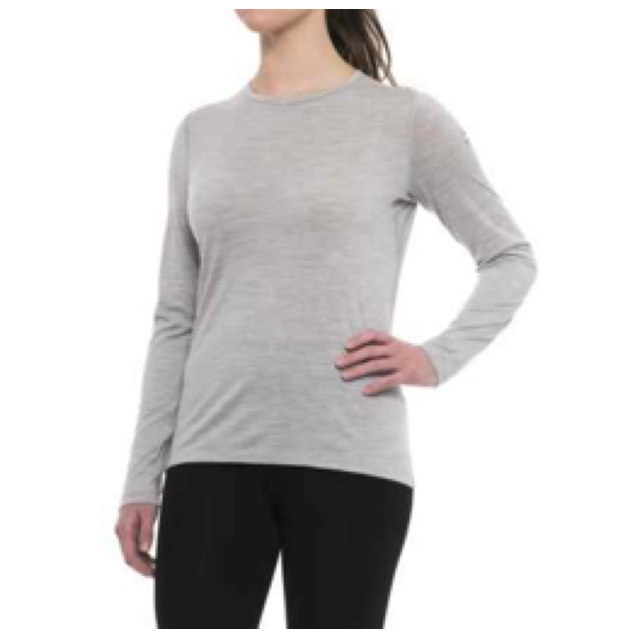

In [14]:
show_image(df_consolidated, idx=None)

In [16]:
from streaming import MDSWriter, LocalDataset
import base64 
import io

image_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Lambda(lambda img: img.convert('RGB')),
    torchvision.transforms.Resize(256, interpolation=InterpolationMode.BICUBIC),
    torchvision.transforms.RandomCrop(256),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.5], [0.5]),
])

def base64_to_numpy(base64_str):
    decoded = base64.b64decode(base64_str)
    buffer = io.BytesIO(decoded)
    array = np.load(buffer)
    return array


class MosaicDataset(LocalDataset):
    def __init__(self, local, transform=None):
        super().__init__(local=local)


    def __getitem__(self, idx):
        data = super().__getitem__(idx)
        data['img'] = image_transforms(data['img'])
        data['t5_pool'] = base64_to_numpy(data['t5_pool'])
        data['vae_output'] = base64_to_numpy(data['vae_output'])
        return data
    
dataset = MosaicDataset(local=PATH + 'dataset/val')
# dataset[0]['img']

In [17]:
dataset[0]['caption']

KeyError: 't5_output'

In [40]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, pin_memory=True)
for batch in dataloader:
    break

batch

{'caption': ['Le Chateau wool coat Chanel brooch minimalist style Vancouver blogger winter outfit idea',
  '7 Techniques For Finishing Beech Woodworking Projects Cherry Wood Stain Woodworking Projects Wood Finishing Techniques',
  'Thread Bangles with multicolours and side bangles with silver stones',
  'Logo Design By Hih7 For House Construction Logo Design   Design #6521089 Part 33'],
 'height': tensor([1035,  825,  678,  755]),
 'id': ['1602751017711', '4224318007528', '3709117019640', '2641198020063'],
 'img': tensor([[[[ 0.9451,  0.9608,  0.9765,  ...,  0.5529,  0.5529,  0.5608],
           [ 0.9451,  0.9608,  0.9686,  ...,  0.5529,  0.5529,  0.5608],
           [ 0.8980,  0.9216,  0.9294,  ...,  0.5529,  0.5608,  0.5529],
           ...,
           [ 0.1922,  0.1843,  0.2471,  ...,  0.0275, -0.0039,  0.0275],
           [ 0.2471,  0.2941,  0.4196,  ...,  0.0353,  0.0353,  0.0353],
           [ 0.3725,  0.3020,  0.3569,  ...,  0.0118, -0.0118,  0.0196]],
 
          [[ 0.8588,  0.

In [21]:
# vae = AutoencoderKL.from_pretrained("ostris/vae-kl-f8-d16", torch_dtype=torch.float16).to("cuda")
# print(vae.config.scaling_factor)
# _ = vae.requires_grad_(False)
# z = vae.encode(torch.Tensor(img).permute(2, 0, 1)[None].to("cuda")).latent_dist.sample()
# img_rec = vae.decode(z).sample

0.24447420268654824


In [8]:
# tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pile-t5-base", use_fast=True)
# tokenizer.pad_token = tokenizer.bos_token
# model = AutoModelForSeq2SeqLM.from_pretrained("EleutherAI/pile-t5-base").to("cuda")
# _ = model.eval()
# model.requires_grad_(False)

In [9]:
captions = df_consolidated['caption'].to_list()

# caption_inputs = tokenizer(
#     captions[:32], max_length=tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt"
# )
# input_ids = caption_inputs["input_ids"].to("cuda")
# encoder_hidden_states = model(
#     input_ids=input_ids, 
#     decoder_input_ids=input_ids, 
#     return_dict=False, 
# )[0]

# model = AutoModel.from_pretrained("google/siglip-so400m-patch14-384", cache_dir='/mnt/sd1tb/cache').to("cuda")#.to(torch.float16)
# processor = AutoProcessor.from_pretrained("google/siglip-so400m-patch14-384", cache_dir='/mnt/sd1tb/cache')
# inputs = processor(text=captions[:32], images=None, padding="max_length", return_tensors="pt")

In [10]:

image_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Lambda(lambda img: img.convert('RGB')),
    torchvision.transforms.Resize(256, interpolation=InterpolationMode.BICUBIC),
    torchvision.transforms.RandomCrop(256),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.5], [0.5]),
])

class Dataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pile-t5-base", use_fast=True)
        self.tokenizer.pad_token = self.tokenizer.bos_token

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe[idx, "path"]
        caption = self.dataframe[idx, "caption"]
        print(caption)
        image = Image.open(img_path)

        # Caption
        caption = self.tokenizer(
            caption, 
            truncation=True,
            max_length=77*3, 
            padding="max_length", 
            return_tensors="pt"
        )
        caption['input_ids'] = caption["input_ids"].squeeze()

        # Image
        if self.transform:
            image = self.transform(image)

        return {"image": image, "caption": caption}
    
dataset = Dataset(df_consolidated, transform=image_transforms)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, pin_memory=True, pin_memory_device="cuda:0")
for batch in dataloader:
    break

AR/WE Sweden (arweswe and arwe sweden) white watch with genuine brown leather strap. Simplistic and minimalistic watch from Sweden for both him and her
webundies com christmas is coming elf on the shelf onesie
British rock band Muse will perform Jan. 28 at Oracle Arena.  Photo: DANIEL ROLAND, AFP/Getty Images / 2012 AFP
A lone prison officer on a prison wing at Winchester Prison, UK. Stock Photo
50x50x5cm Black Aquarium Biochemical Cotton Filter Foam Fish Tank Sponge Pads
Hairstyles For Mehndi Party : Natasha salon. mehndi look bridal pinterest salon
Kim sits in the pilot's seat of a fighter jet during the inspection
3 France shaped stickers flag crest decal bumper car bike emblem vinyl CN015
k nex swing ride instructions k nex swing ride building set k nex original building
Cermalon 5-Piece Ceramic Set, Aluminium, Copper, 46 x 29 x 13 cm
You're the Avocado to my toast Funny love valentine's day t-RT
ACSUSS Boys Girls Halloween Cosplay Outfits Policeman/Fireman/Doctor Costumes with Acc

In [8]:
bits = 1 << 29
megabits = bits / 1e6
print(megabits)

536.870912


In [11]:
vae = AutoencoderKL.from_pretrained("ostris/vae-kl-f8-d16").to("cuda").to(torch.float16)
_ = vae.requires_grad_(False)

In [12]:
with torch.cuda.amp.autocast():
    z = vae.encode(batch['image'].to('cuda')).latent_dist.sample()
    rec = vae.decode(z).sample #/ vae.config.scaling_factor

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9137255..1.0].


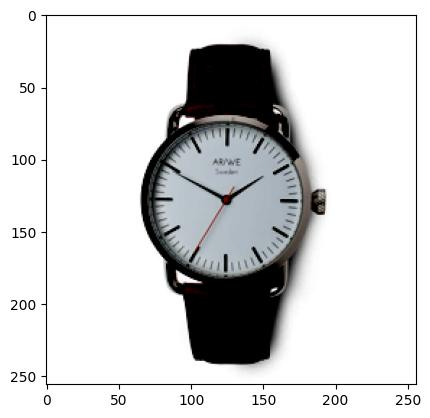

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9824219..1.0830078].


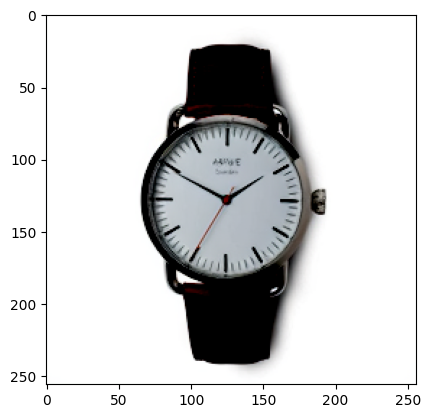

In [13]:
plt.imshow(batch['image'][0].permute(1, 2, 0)); plt.show();
plt.imshow(rec[0].float().permute(1, 2, 0).cpu());plt.show()

In [34]:
torch.cuda.empty_cache()
t5model = AutoModelForSeq2SeqLM.from_pretrained("EleutherAI/pile-t5-base").to("cuda").to(torch.float16)
t5model.requires_grad_(False)
t5_inputs = {k: v.to("cuda") for k, v in batch['caption'].items()}
with torch.cuda.amp.autocast(), torch.inference_mode():
    t5_outputs = t5model.encoder(**t5_inputs)[0]
mask = t5_inputs["attention_mask"].permute(0, 2, 1).expand(t5_outputs.shape)
t5_outputs = t5_outputs * mask